In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

## 1. Обучаем простенькую сверточную нейронку

In [ ]:
transform = T.ToTensor()
train_set = CIFAR10('CIFAR10', train=True, download=True,
                    transform=transform)
test_set = CIFAR10('CIFAR10', train=False, download=True,
                   transform=transform)
len(train_set), len(test_set)

100%|██████████| 170498071/170498071 [00:01<00:00, 89962162.04it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


(50000, 10000)

In [ ]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Class: horse


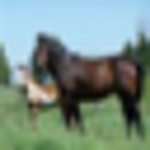

In [ ]:
item = 12
print(f'Class: {train_set.classes[train_set[item][1]]}')
T.ToPILImage()(train_set[item][0]).resize((150, 150))

In [ ]:
train_set[item][0].shape

torch.Size([3, 32, 32])

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, pin_memory=True, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, pin_memory=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
from torch import nn

class ConvNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=4, padding=1),
            nn.MaxPool2d(3, stride=2), 
            nn.BatchNorm2d(32), 
            nn.Dropout(0.3), 
            nn.ReLU(), 

            # nn.Conv2d(32, 64, 3, stride=4, padding=1),
            # nn.MaxPool2d(2, stride=2), 
            # nn.BatchNorm2d(64), 
            # nn.Dropout(0.3), 
            # nn.ReLU(), 

            nn.Flatten(),
            nn.Linear(288, 144),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(144, 10)

        )
        
        self.head = nn.Softmax(dim=1)
        
    def forward(self, images):
        features = self.features(images)
        # features = features.mean(dim=(2, 3))
        logits = self.head(features)
        return logits

In [ ]:
model = ConvNet().to(device)
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [ ]:
!pip3 install torchinfo
from collections import defaultdict
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
summary(model, (32, 3, 32, 32))


/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 32, 8, 8]            896
│    └─MaxPool2d: 2-2                    [32, 32, 3, 3]            --
│    └─BatchNorm2d: 2-3                  [32, 32, 3, 3]            64
│    └─Dropout: 2-4                      [32, 32, 3, 3]            --
│    └─ReLU: 2-5                         [32, 32, 3, 3]            --
│    └─Flatten: 2-6                      [32, 288]                 --
│    └─Linear: 2-7                       [32, 144]                 41,616
│    └─Dropout: 2-8                      [32, 144]                 --
│    └─ReLU: 2-9                         [32, 144]                 --
│    └─Linear: 2-10                      [32, 10]                  1,450
├─Softmax: 1-2                           [32, 10]                  --
Total p

In [ ]:
for images, labels in train_loader:
    break

In [ ]:
with torch.no_grad():
    images = images.to(device)
    logits = model(images)
logits.shape

torch.Size([32, 10])

In [ ]:
import time
from sklearn.metrics import f1_score


In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        f1 и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('f1 score', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('score', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    schedular,
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) f1_score и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты на выходе модели
            logits = model(X_batch)
            
            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += f1_score(y_batch.cpu().numpy(), y_pred, average="macro")

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты, полученные моделью
            logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += f1_score(y_batch.cpu().numpy(), y_pred, average="macro")

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # optimization scheduler
        scheduler.step(val_loss)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training f1_score: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation f1_score: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Epoch 49 of 100 took 20.396s
  training loss (in-iteration): 	1.949410
  validation loss (in-iteration): 	1.915236
  training f1_score: 			46.18 %
  validation f1_score: 			49.00 %


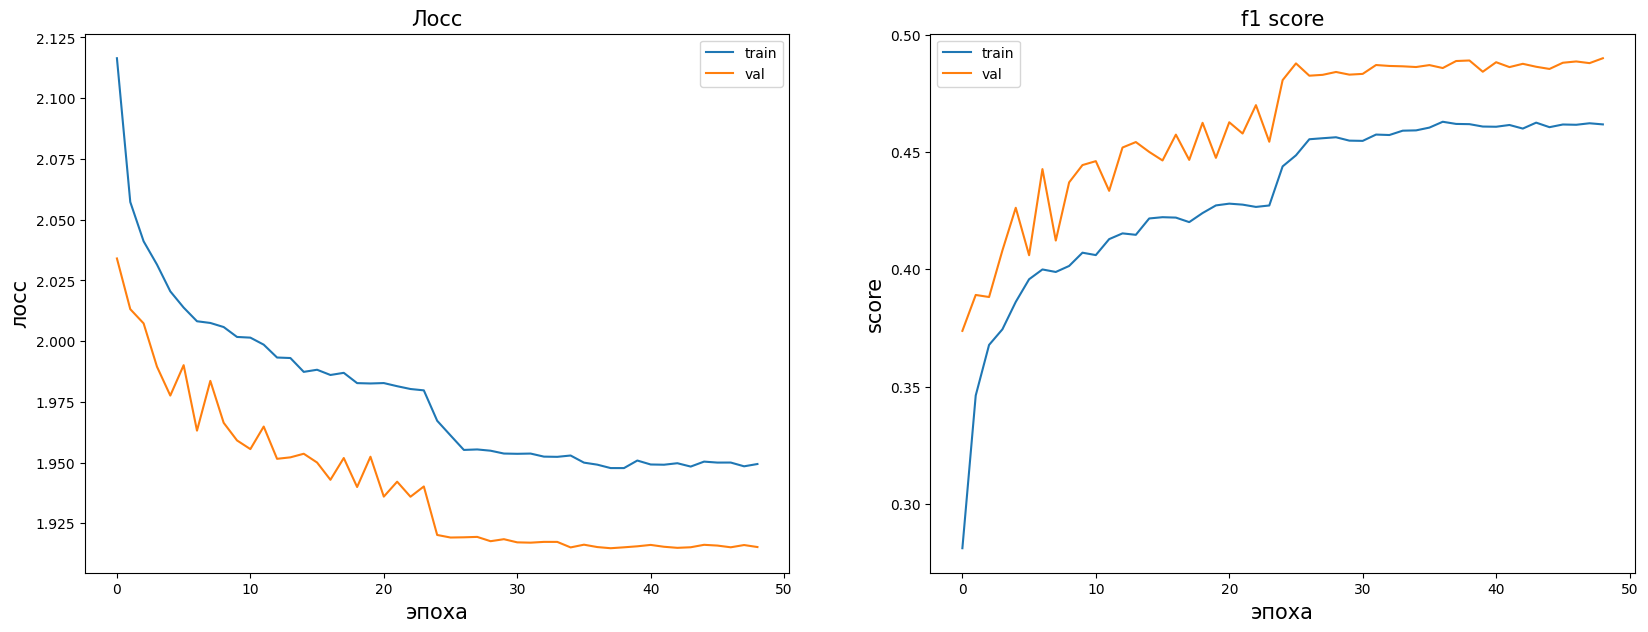

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KeyboardInterrupt: ignored

In [ ]:
model, history = train(
    model, criterion, optimizer, scheduler,
    train_loader, test_loader, 
    num_epochs=epochs
)

Остановка обучения в связи с выходом на плато, метрика хорошая

## 2. Добавляем аугментации

In [ ]:
def get_cifar10_transform(size, train=True):
    if train:
        transform = T.Compose([
            T.ToTensor(), 
            T.RandomRotation(10),
            T.Normalize((0.49, 0.5, 0.45), (0.2, 0.19, 0.22))
        ])

    else:
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    return transform

In [ ]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
train_set = CIFAR10('CIFAR10', train=True, download=True,
                    transform=get_cifar10_transform(32, train=True))
test_set = CIFAR10('CIFAR10', train=False, download=True,
                   transform=get_cifar10_transform(32, train=False))
len(train_set), len(test_set)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

Class: horse


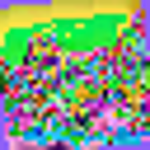

In [ ]:
item = 12
print(f'Class: {train_set.classes[train_set[item][1]]}')
T.ToPILImage()(train_set[item][0]).resize((150, 150))

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, pin_memory=True, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, pin_memory=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

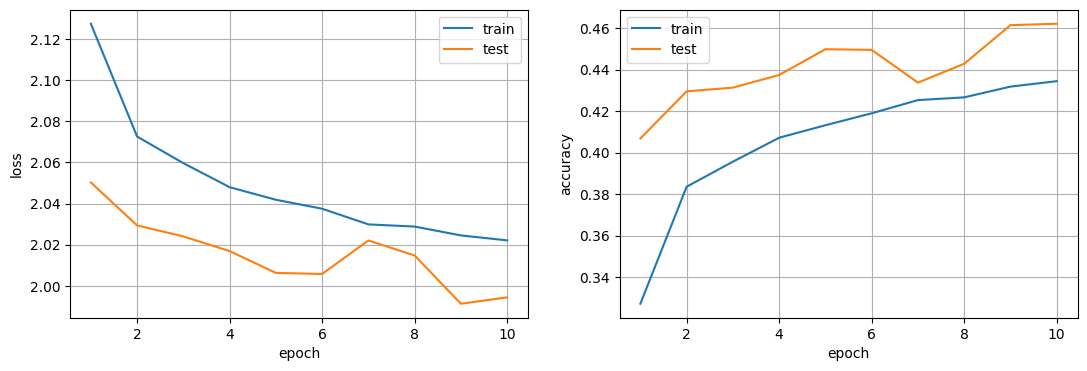

Training 11/25:   0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 25

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]
    
    model.eval()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')

Поучили немного, и хватит, в этот раз смотрели accuracy, так как мне не хотелось переписывать под себя готовый код из исходника ноутбука

## 3. Пробуем архитектуру из torchvision

[Данные](https://www.kaggle.com/lantian773030/pokemonclassification)

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"radiatalycoris","key":"7ee49b0610252be457d2c724427c6ab5"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d lantian773030/pokemonclassification

 95% 396M/417M [00:02<00:00, 134MB/s]
100% 417M/417M [00:02<00:00, 155MB/s]


In [ ]:
!unzip -q /content/pokemonclassification.zip -d /content
!rm /content/pokemonclassification.zip

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

classes = os.listdir('PokemonData')
os.mkdir('PokemonData/train/')
os.mkdir('PokemonData/test/')

for class_name in classes:
    os.mkdir(f'PokemonData/train/{class_name}')
    os.mkdir(f'PokemonData/test/{class_name}')

    objects = os.listdir(f'PokemonData/{class_name}')
    train_objects, test_objects = train_test_split(objects, test_size=0.2)
    
    for object_name in train_objects:
        os.rename(f'PokemonData/{class_name}/{object_name}',
                  f'PokemonData/train/{class_name}/{object_name}')
    
    for object_name in test_objects:
        os.rename(f'PokemonData/{class_name}/{object_name}',
                  f'PokemonData/test/{class_name}/{object_name}')
    
    shutil.rmtree(f'PokemonData/{class_name}')

In [ ]:
from torchvision.datasets import ImageFolder

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

train_set = ImageFolder('PokemonData/train/', transform=train_transform)
test_set = ImageFolder('PokemonData/test/', transform=test_transform)
len(train_set), len(test_set)

(5391, 1429)

Golbat


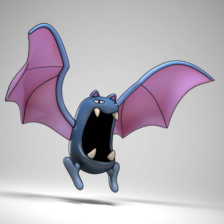

In [ ]:
item = 1445
print(train_set.classes[train_set[item][1]])
T.ToPILImage()(train_set[item][0])

In [ ]:
num_classes = len(train_set.classes)
print('Число классов:', num_classes)

Число классов: 150


In [ ]:
train_loader = DataLoader(train_set, batch_size=32, pin_memory=True, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, pin_memory=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.models import resnet18

model = #select model resnet18 pretraining = False
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
model

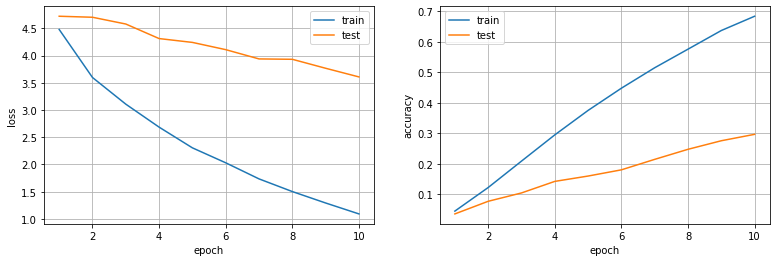

Best test accuracy: 0.2969187675070028


In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]
    
    model.eval()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')

## 4. Файн-тюним

In [ ]:
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

train_set = ImageFolder('PokemonData/train/', transform=train_transform)
test_set = ImageFolder('PokemonData/test/', transform=test_transform)
len(train_set), len(test_set)

(5391, 1429)

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, pin_memory=True, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, pin_memory=True, num_workers=4)

In [ ]:
model = resnet18(pretrained=True)
# replace model head
for param in model.parameters():
    param.requires_grad = False

model.head = torch.nn.Sequential(nn.Linear(in_features=2048, out_features=256, bias=True),
                                         nn.ReLU(),
                                         nn.Linear(in_features=256, out_features=128, bias=True),
                                         nn.ReLU(),
                                         nn.Linear(in_features=128, out_features=3, bias=True))


model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

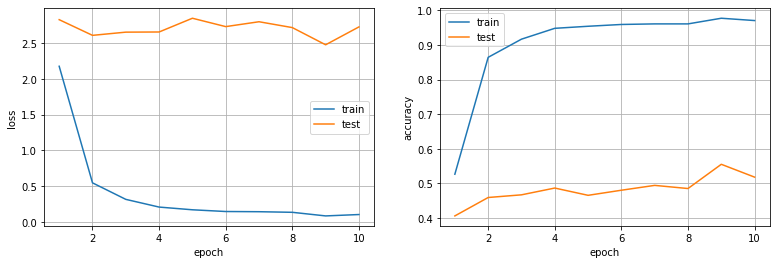

Best test accuracy: 0.5553221288515406


In [ ]:
new_train_losses, new_test_losses = [], []
new_train_accuracies, new_test_accuracies = [], []
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    new_train_losses += [running_loss / len(train_loader.dataset)]
    new_train_accuracies += [running_accuracy / len(train_loader.dataset)]
    
    model.eval()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    new_test_losses += [running_loss / len(test_loader.dataset)]
    new_test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(new_train_losses, new_test_losses, new_train_accuracies, new_test_accuracies)

print(f'Best test accuracy: {max(new_test_accuracies)}')

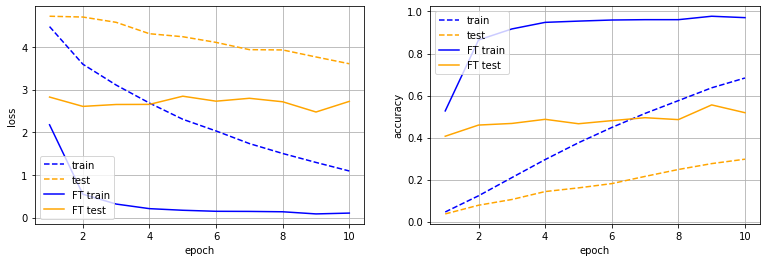

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', color='blue', linestyle='--')
axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test', color='orange', linestyle='--')
axs[0].plot(range(1, len(new_train_losses) + 1), new_train_losses, label='FT train', color='blue')
axs[0].plot(range(1, len(new_test_losses) + 1), new_test_losses, label='FT test', color='orange')
axs[0].set_ylabel('loss')

axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train', color='blue', linestyle='--')
axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test', color='orange', linestyle='--')
axs[1].plot(range(1, len(new_train_accuracies) + 1), new_train_accuracies, color='blue', label='FT train')
axs[1].plot(range(1, len(new_test_accuracies) + 1), new_test_accuracies, color='orange', label='FT test')
axs[1].set_ylabel('accuracy')

for ax in axs:
    ax.grid()
    ax.set_xlabel('epoch')
    ax.legend()

plt.show()